In [1]:
import numpy as np
import torch, sys
from torchvision.transforms import functional as func
import torchvision.transforms as transforms
from loss import ComputeLoss
import yaml, random
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
from new_model import Model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
from torch.utils.data import DataLoader

from dataloader import FiftyOneTorchDataset
from util import non_max_suppression


In [2]:
dataset_train = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    # label_types=[""],
    classes=["cat", "dog"],
    max_samples=128,
)

Found annotations at 'C:\Users\kevin\fiftyone\coco-2017\raw\instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-128'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:

dataset_validation = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    # label_types=[""],
    classes=["cat", "dog"],
    max_samples=64,
)

Found annotations at 'C:\Users\kevin\fiftyone\coco-2017\raw\instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-64'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:

dataset_train.persistent = True
dataset_validation.persistent = True
view_train = dataset_train.filter_labels("ground_truth", F("label").is_in(("cat", "dog")))
view_val = dataset_validation.filter_labels("ground_truth", F("label").is_in(("cat", "dog")))
view_train = view_train.take(2, seed=61)
view_val = view_val.take(2, seed=61)

fil_classes = ["cat", "dog"]
device = torch.device('cuda:0')

with open("hyp.yaml", "r") as stream:
    try:
        hyp = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


org_w = 640
org_h = 480
scaling_factor = 640/480

batch_size = 2

transform = transforms.Compose([transforms.Resize((int(org_h/scaling_factor), int(org_w/scaling_factor))),
                                transforms.Pad((0, int((org_w - org_h)/(2*scaling_factor)),0,int((org_w - org_h)/(2*scaling_factor)))),
                                transforms.ToTensor()])
            
dataset_train = FiftyOneTorchDataset(view_train, transform, classes=fil_classes)
dataset_val = FiftyOneTorchDataset(view_val, transform, classes=fil_classes)
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True)



In [6]:

model = Model('yolov3.cfg', hyp=hyp).to(device)

optimizer = torch.optim.Adam(model.parameters(),1e-3)
loss_fcn = ComputeLoss(model)
#training
train_loss_list = []
val_loss_list = []
# Add predictions to samples\
epochs = 100
for epoch in range(epochs):
    #training
    tot_loss = 0
    count = 0
    for images, targets in loader_train:
        model.train()
        optimizer.zero_grad()
        images = images.to(device)
        targets = targets.to(device)
        preds = model(images)
        loss, loss_parts = loss_fcn(preds, targets)
        tot_loss += loss / batch_size
        count += 1
        loss.backward()
        optimizer.step()
        
    #save the model each 50 epochs
    if epoch%50==0 and epoch!=0:
        torch.save(model,'./models/model'+str(epoch)+'.pt')
    print(epoch, 'Training:\t',epoch, tot_loss.item()/count)
    train_loss_list.append(tot_loss.item()/count)
    
    #validation
    tot_loss = 0
    count = 0
    for images, targets in loader_val:
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            preds = model(images)
            loss, loss_parts = loss_fcn(preds, targets)
            tot_loss += loss / batch_size
        count += 1
    print('\tValidation:\t', tot_loss.item()/count)
    val_loss_list.append(tot_loss.item()/count)

torch.save(model,'./models/final'+'.pt')    

from util import my_load,my_save
my_save('trainloss',train_loss_list)
my_save('validationloss',val_loss_list)

#  TODO: val code, val dataloader, save model, save training loss



training 0 1.4252794981002808
validation 0 1.0478429794311523
training 1 0.6628555655479431
validation 1 0.8485488891601562
training 2 1.7965223789215088
validation 2 0.7870944142341614
training 3 0.42887723445892334
validation 3 0.8079826235771179
training 4 0.40725645422935486
validation 4 0.9592370390892029
training 5 0.37038230895996094
validation 5 0.9204366207122803
training 6 0.36081886291503906
validation 6 1.2298139333724976
training 7 0.9506109952926636
validation 7 1.2262012958526611
training 8 0.34351998567581177
validation 8 1.2039974927902222
training 9 0.8719376921653748
validation 9 0.7490473389625549
training 10 0.8617871999740601
validation 10 1.1365151405334473
training 11 0.33429789543151855
validation 11 0.7572731971740723
training 12 0.8291689157485962
validation 12 0.763347864151001
training 13 0.8055920004844666
validation 13 0.7733945846557617
training 14 0.7713519334793091
validation 14 0.7901402115821838
training 15 0.34441226720809937
validation 15 1.0487606

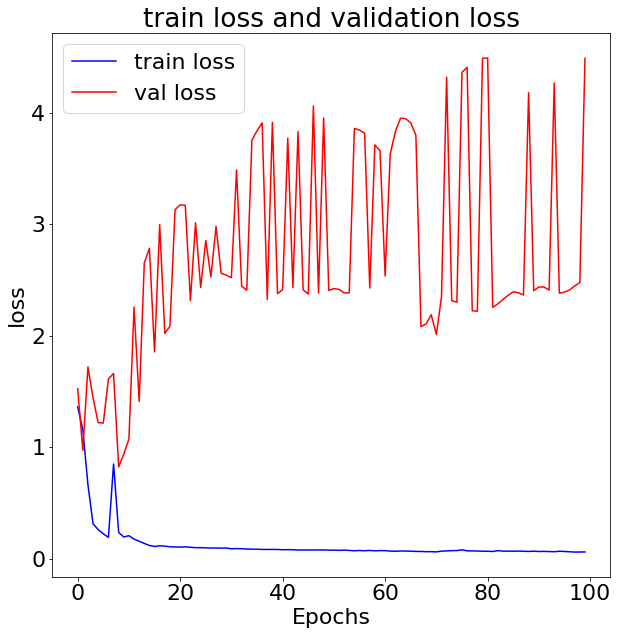

In [ ]:
from util import plot
plot(train_loss_list,val_loss_list,'train loss','val loss','loss','train loss and validation loss')

In [ ]:
from util import my_img_plot
import gc
gc.collect() 
torch.cuda.empty_cache()
device = torch.device('cuda:0')
model = torch.load('./models/final.pt').to(device)




2
torch.Size([2, 14175, 7])
torch.Size([3, 480, 480])


C:\Users\kevin\miniconda3\envs\python38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Figure size 432x288 with 0 Axes>

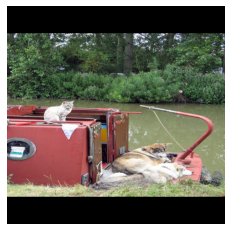

In [ ]:

model.eval()
for images, targets in loader_train:
    # for image in images:
    images = images.to(device)
    with torch.no_grad():
        pred = model(images)
        print(len(pred))
        print(pred[0].shape)
        print(images[0].shape)
        my_img_plot(pred[0],images[0],fil_classes,1)
    # break